## Each algorithm

--- Analyzing: CEGAR_PRED ---


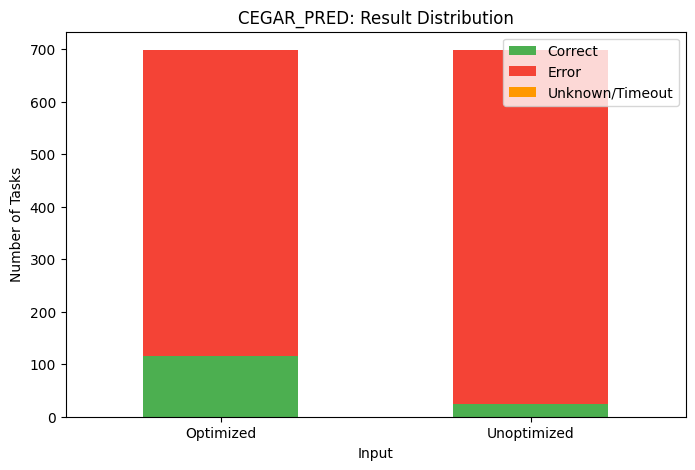

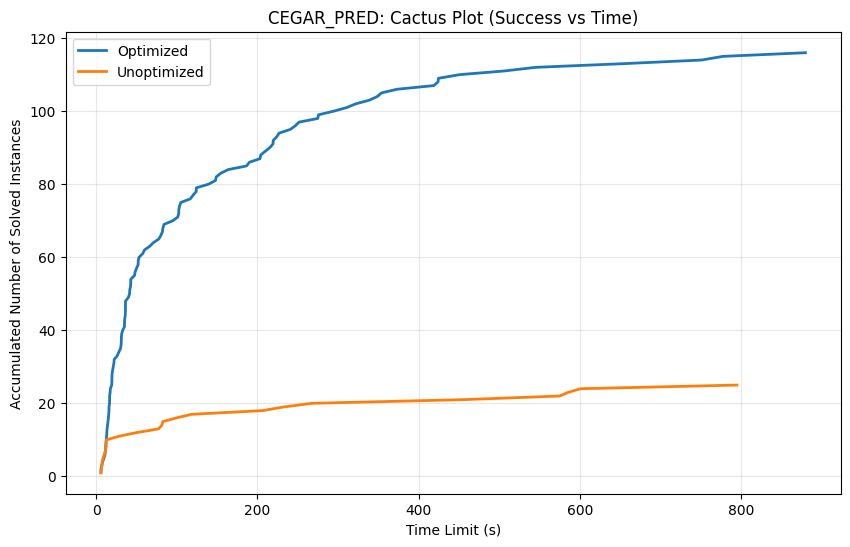

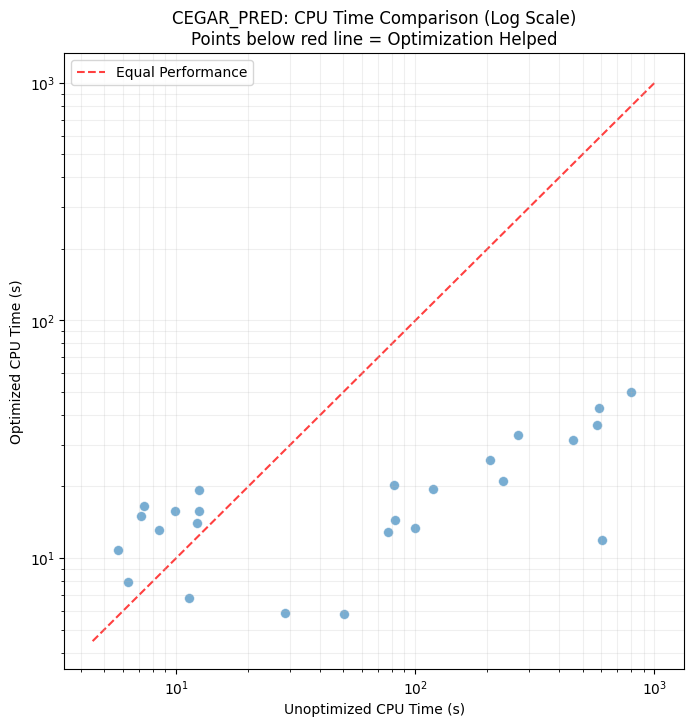



--- Analyzing: CEGAR_EXPL ---


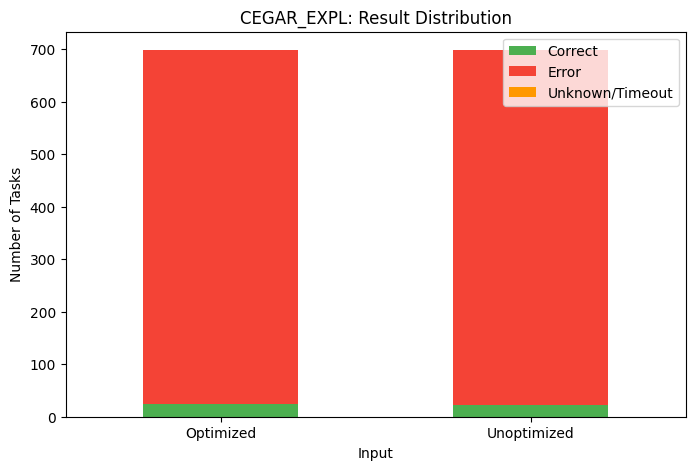

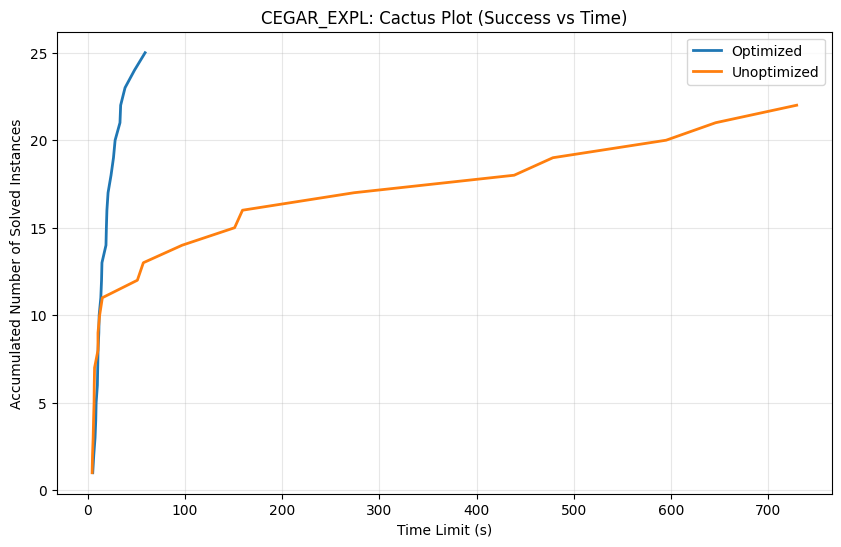

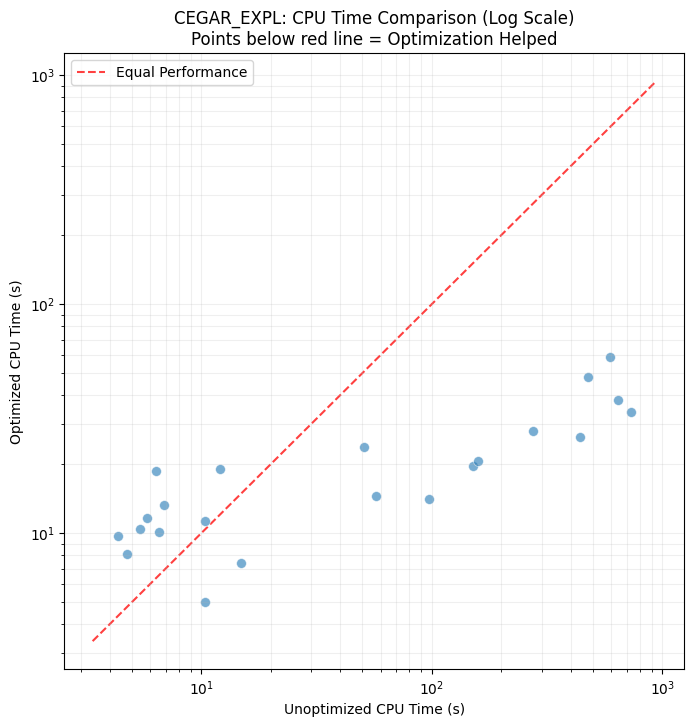



--- Analyzing: BMC ---


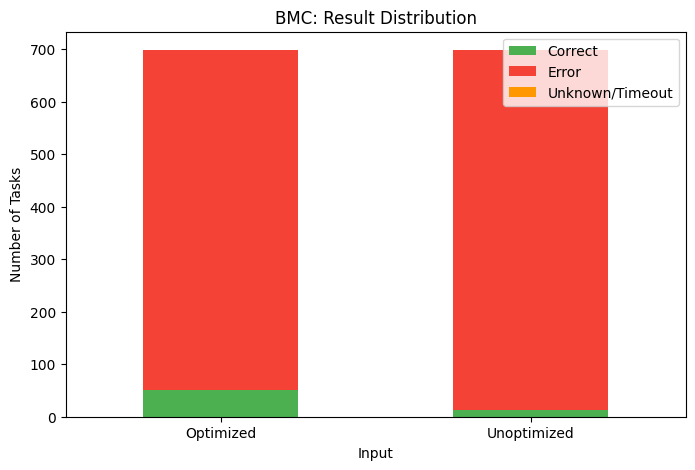

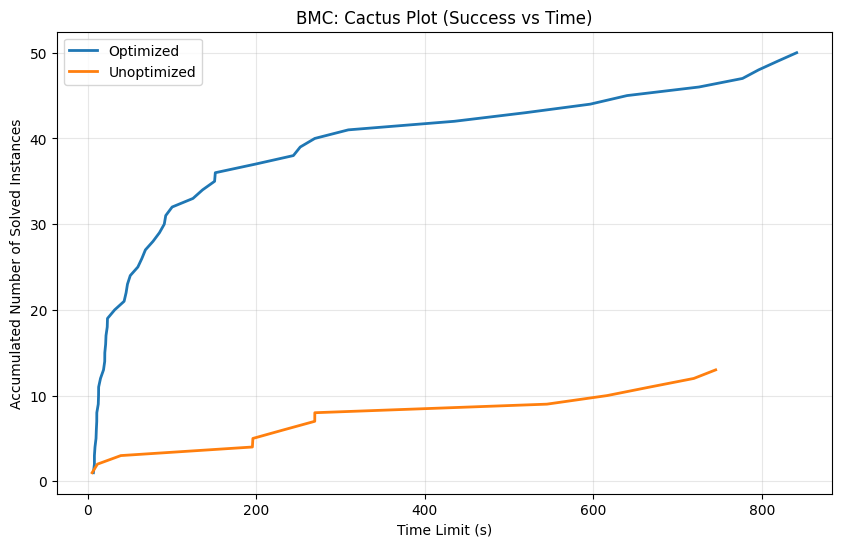

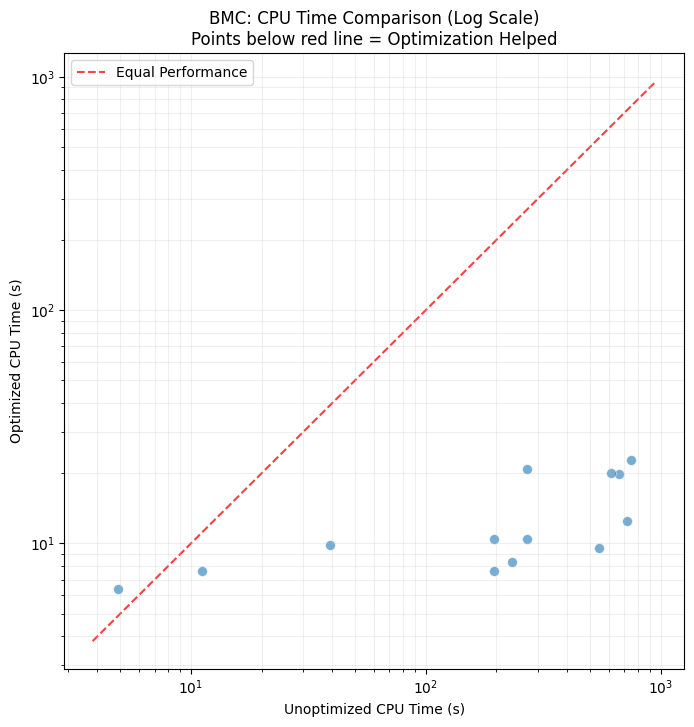



--- Analyzing: IMC ---


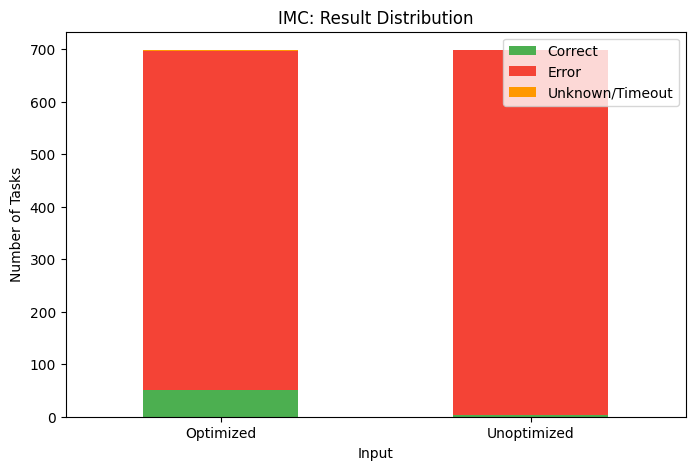

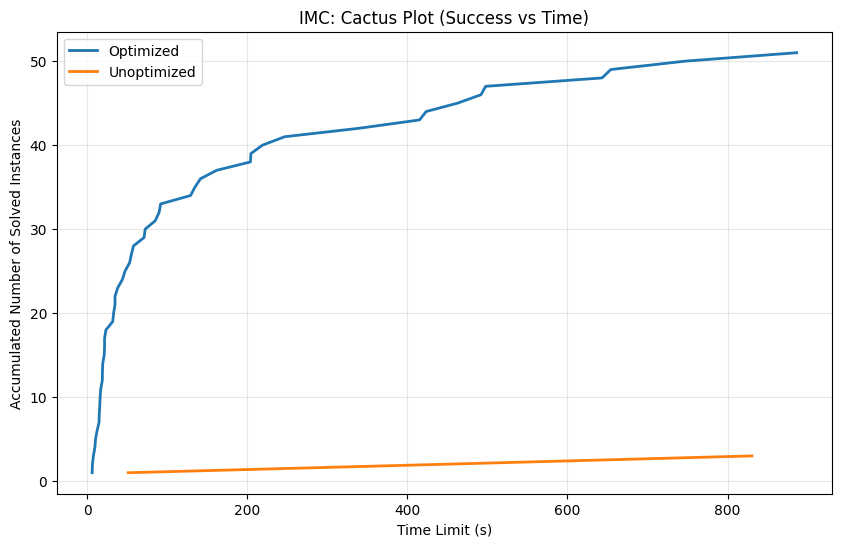

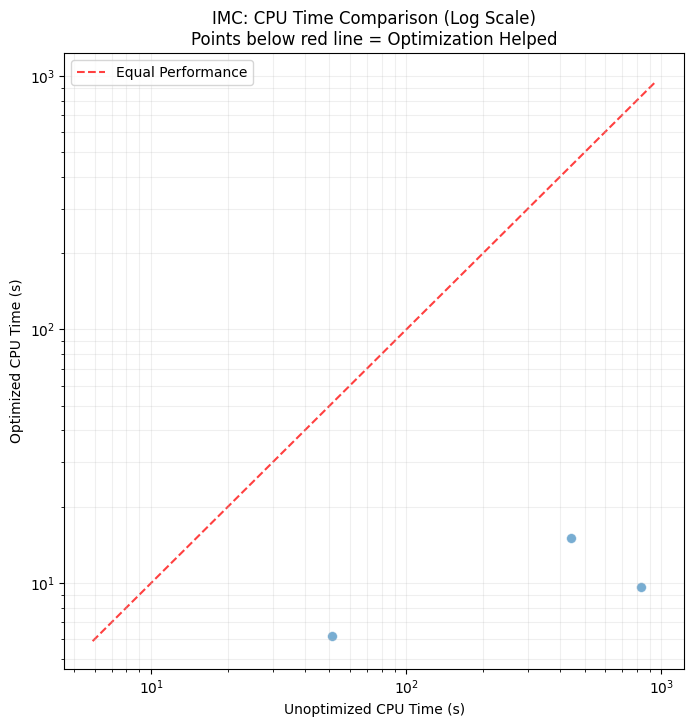



--- Analyzing: K-Induction ---


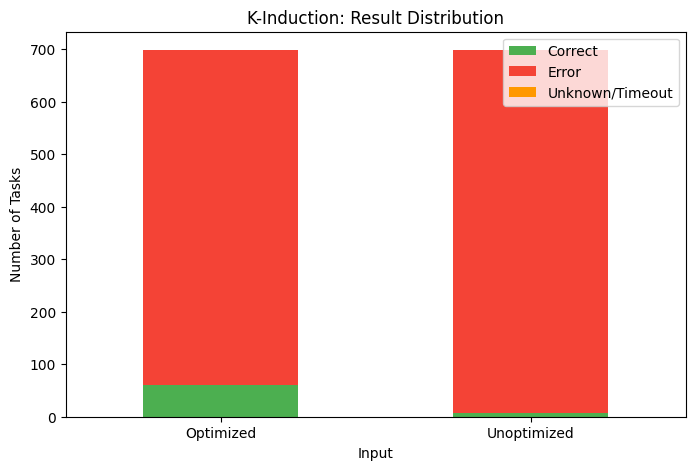

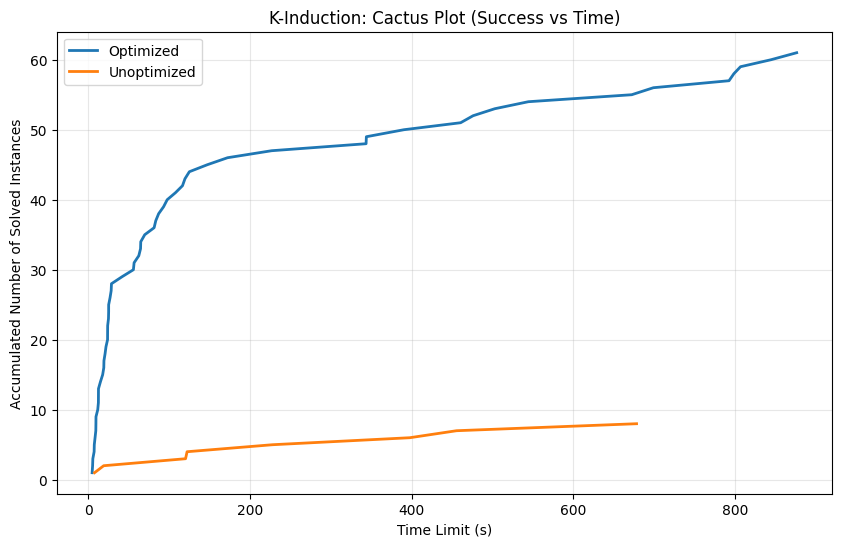

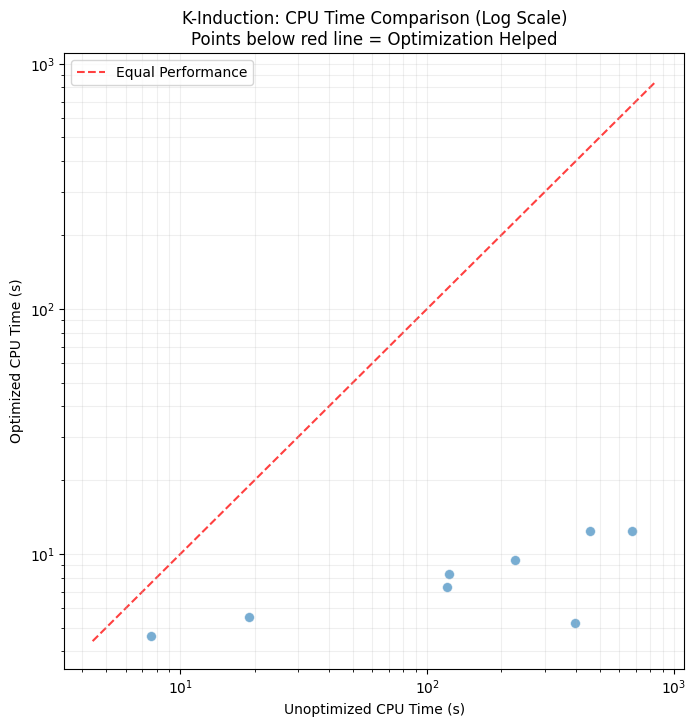

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
DATA_FOLDER = "result_xmls_btor2"

# Format: ("Algorithm", "Optimized File", "Unoptimized File")
PAIRS = [
    ("CEGAR_PRED", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-pred-cegar.btor2-pred.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-pred-cegar.btor2-pred.xml")),
    ("CEGAR_EXPL", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-expl-cegar.btor2-expl.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-expl-cegar.btor2-expl.xml")),
    ("BMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-bounded.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-bounded.btor2.xml")),
    ("IMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-imc.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-imc.btor2.xml")),
    ("K-Induction", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-kind.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-kind.btor2.xml")),
]

# --- 1. XML Parsing Function ---
def parse_benchexec_xml(filepath):
    """Parses BenchExec XML and returns a DataFrame with clean types."""
    if not os.path.exists(filepath):
        print(f"Warning: File not found: {filepath}")
        return None

    tree = ET.parse(filepath)
    root = tree.getroot()
    
    data = []
    
    for run in root.findall('.//run'):
        file_name = run.get('name')
        cols = {elem.get('title'): elem.get('value') for elem in run.findall('column')}
        
        status = cols.get('status', run.get('status'))
        category = cols.get('category', run.get('category'))
        
        # Clean CPU Time
        cpu_time = cols.get('cputime', 'nan')
        if isinstance(cpu_time, str):
            cpu_time = float(cpu_time.replace('s', ''))
            
        # Clean Memory
        memory = cols.get('memory', 'nan')
        if isinstance(memory, str):
            memory = float(memory.replace('B', '')) / (1024 * 1024) # MB

        # Normalize Name
        base_name = os.path.splitext(os.path.basename(file_name))[0]

        data.append({
            'base_name': base_name,
            'full_name': file_name,
            'status': status,
            'category': category,
            'cputime': cpu_time,
            'memory_mb': memory
        })
        
    return pd.DataFrame(data)

# --- 2. Visualization Functions ---

def plot_cpu_scatter(df, algo_name):
    """Scatter plot: Unoptimized (x) vs Optimized (y)"""
    plt.figure(figsize=(8, 8))
    
    # Filter only where both solved correctly
    correct_df = df[(df['category_opt'] == 'correct') & (df['category_no_opt'] == 'correct')]
    
    plt.xscale('log')
    plt.yscale('log')
    
    # x = Unoptimized, y = Optimized
    sns.scatterplot(data=correct_df, x='cputime_no_opt', y='cputime_opt', alpha=0.6, s=50)
    
    # Diagonal line
    lims = [
        min(plt.xlim()[0], plt.ylim()[0]), 
        max(plt.xlim()[1], plt.ylim()[1])
    ]
    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Equal Performance')
    
    plt.title(f"{algo_name}: CPU Time Comparison (Log Scale)\nPoints below red line = Optimization Helped")
    plt.xlabel("Unoptimized CPU Time (s)")
    plt.ylabel("Optimized CPU Time (s)")
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

def plot_cactus(df_opt, df_no_opt, algo_name):
    """Cactus plot: Sorted time vs Number of solved instances"""
    plt.figure(figsize=(10, 6))
    
    for label, data in [('Optimized', df_opt), ('Unoptimized', df_no_opt)]:
        solved = data[data['category'] == 'correct']['cputime'].sort_values().reset_index(drop=True)
        plt.plot(solved, solved.index + 1, label=label, linewidth=2)
        
    plt.title(f"{algo_name}: Cactus Plot (Success vs Time)")
    plt.xlabel("Time Limit (s)")
    plt.ylabel("Accumulated Number of Solved Instances")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_status_bars(df_opt, df_no_opt, algo_name):
    """Compare success/fail counts"""
    def get_counts(df, label):
        counts = df['category'].value_counts()
        return {
            'Input': label,
            'Correct': counts.get('correct', 0),
            'Error': counts.get('error', 0),
            # Uncommented this to show full picture (timeouts/unknowns)
            'Unknown/Timeout': len(df) - counts.get('correct', 0) - counts.get('error', 0) 
        }

    stats = pd.DataFrame([get_counts(df_opt, 'Optimized'), get_counts(df_no_opt, 'Unoptimized')])
    
    # Plotting
    # Colors: Green (Correct), Red (Error), Orange (Timeout)
    stats.set_index('Input').plot(kind='bar', stacked=True, color=['#4CAF50', '#F44336', '#FF9800'], figsize=(8, 5))
    plt.title(f"{algo_name}: Result Distribution")
    plt.ylabel("Number of Tasks")
    plt.xticks(rotation=0)
    plt.show()

# --- 3. Main Execution Loop ---

for algo_name, opt_file, no_opt_file in PAIRS:
    print(f"--- Analyzing: {algo_name} ---")
    
    df_opt = parse_benchexec_xml(opt_file)
    df_no_opt = parse_benchexec_xml(no_opt_file)
    
    if df_opt is not None and df_no_opt is not None:
        # Merge for direct comparison
        # Suffixes: _opt vs _no_opt
        merged_df = pd.merge(
            df_opt, 
            df_no_opt, 
            on='base_name', 
            how='inner', 
            suffixes=('_opt', '_no_opt')
        )
        
        # 1. Status Bar Chart
        plot_status_bars(df_opt, df_no_opt, algo_name)
        
        # 2. Cactus Plot
        plot_cactus(df_opt, df_no_opt, algo_name)
        
        # 3. Scatter Plot
        if len(merged_df) > 0:
            plot_cpu_scatter(merged_df, algo_name)
        else:
            print("No matching benchmark names found (check file naming conventions).")
            
    print("\n" + "="*50 + "\n")

## All Algos

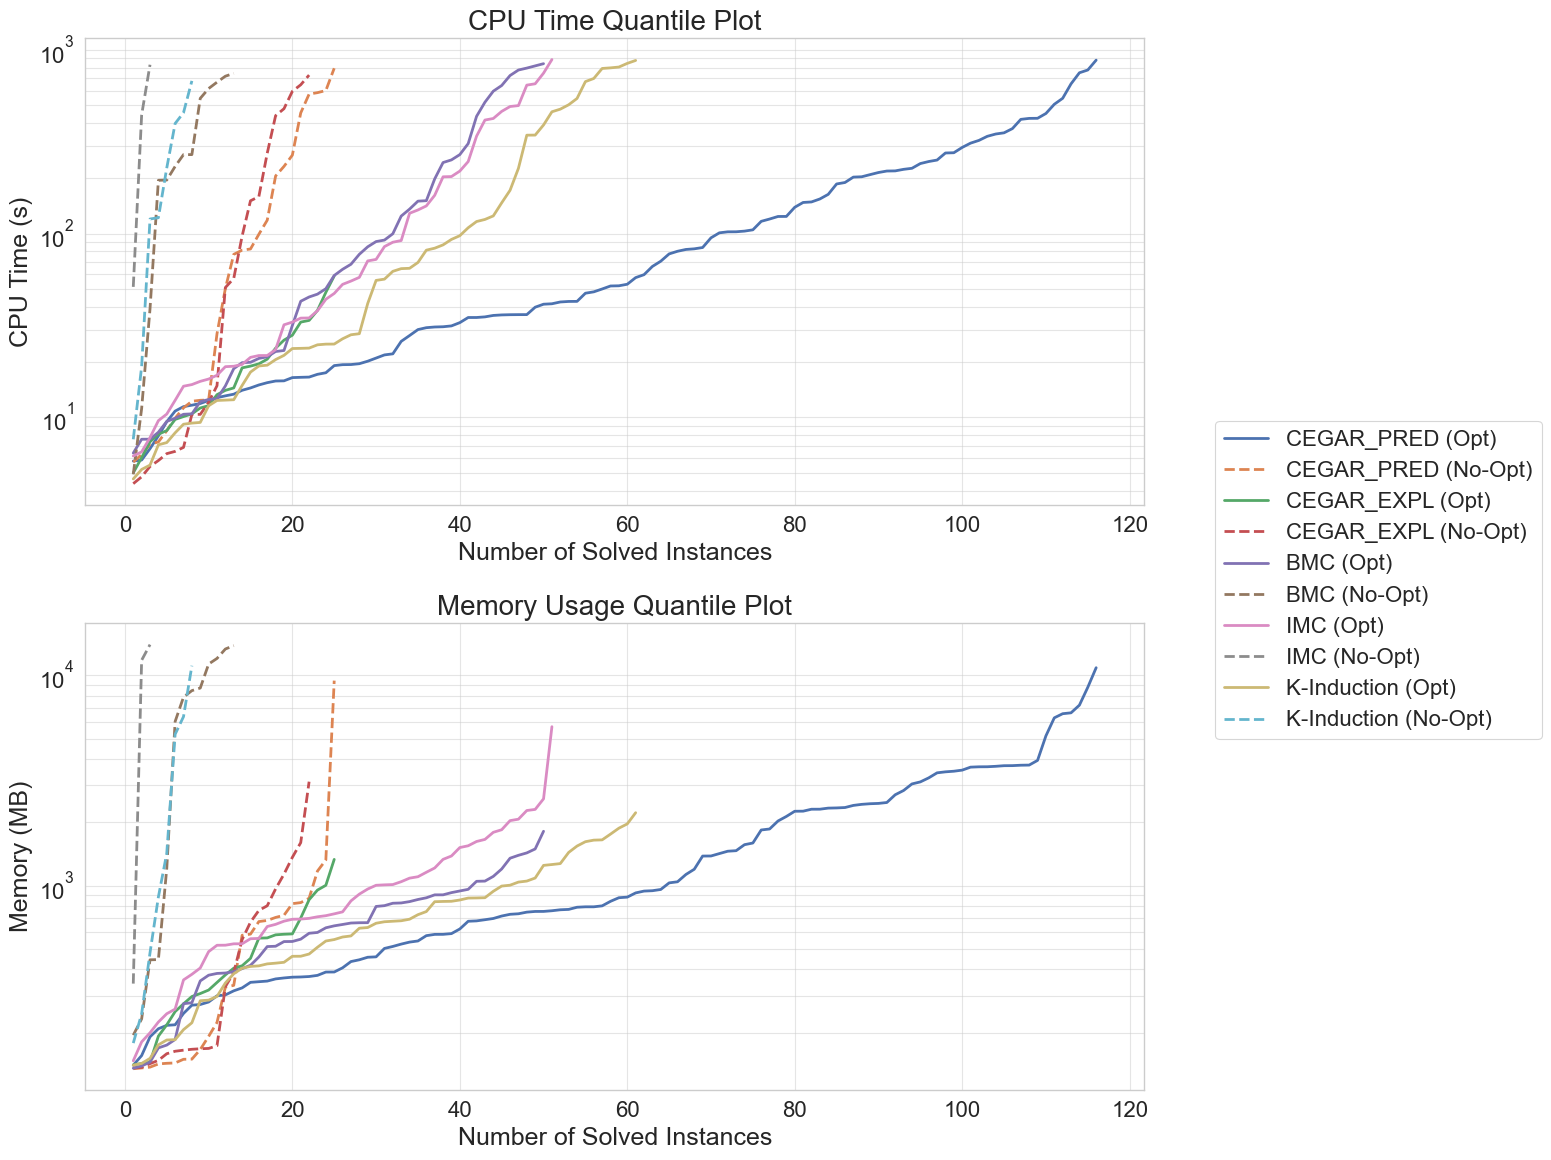

In [8]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- Configuration ---
DATA_FOLDER = "result_xmls_btor2"

# Format: ("Algorithm", "Optimized File", "Unoptimized File")
PAIRS = [
    ("CEGAR_PRED", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-pred-cegar.btor2-pred.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-pred-cegar.btor2-pred.xml")),
    ("CEGAR_EXPL", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-expl-cegar.btor2-expl.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-expl-cegar.btor2-expl.xml")),
    ("BMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-bounded.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-bounded.btor2.xml")),
    ("IMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-imc.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-imc.btor2.xml")),
    ("K-Induction", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-kind.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-kind.btor2.xml")),
]

# --- Helper Function ---
def get_file_data(filepath):
    """
    Parses XML file and returns:
    1. Stats dictionary (for bar charts)
    2. Raw lists of CPU times and Memories (for quantile plots)
    """
    if not os.path.exists(filepath):
        print(f"Warning: File not found: {filepath}")
        return None, None

    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        
        cputimes = []
        memories = []
        total_count = 0
        success_count = 0
        
        for run in root.findall('.//run'):
            total_count += 1
            cols = {elem.get('title'): elem.get('value') for elem in run.findall('column')}
            category = cols.get('category', run.get('category'))
            
            if category == 'correct':
                success_count += 1
                t_str = cols.get('cputime', '0s')
                if t_str.endswith('s'): cputimes.append(float(t_str.replace('s', '')))
                m_str = cols.get('memory', '0B')
                if m_str.endswith('B'): memories.append(float(m_str.replace('B', '')) / (1024 * 1024))

        success_rate = (success_count / total_count * 100) if total_count > 0 else 0
        
        # Calculate stats for bar charts
        if cputimes:
            avg_cpu, med_cpu, std_cpu = np.mean(cputimes), np.median(cputimes), np.std(cputimes)
        else:
            avg_cpu = med_cpu = std_cpu = 0
            
        if memories:
            avg_mem, med_mem, std_mem = np.mean(memories), np.median(memories), np.std(memories)
        else:
            avg_mem = med_mem = std_mem = 0
        
        stats = {
            'success_rate': success_rate,
            'avg_cpu': avg_cpu, 'med_cpu': med_cpu, 'std_cpu': std_cpu,
            'avg_mem': avg_mem, 'med_mem': med_mem, 'std_mem': std_mem
        }
        
        # Raw data for quantile plots (must be sorted!)
        raw_data = {
            'cputimes': sorted(cputimes),
            'memories': sorted(memories)
        }
        
        return stats, raw_data

    except Exception as e:
        print(f"Error parsing {filepath}: {e}")
        return None, None

# --- Main Processing ---
summary_data = []
quantile_data = [] # Store raw data here

for algo_name, opt_file, no_opt_file in PAIRS:
    # 1. Optimized
    stats_opt, raw_opt = get_file_data(opt_file)
    if stats_opt:
        stats_opt.update({'Algorithm': algo_name, 'Configuration': 'Optimized'})
        summary_data.append(stats_opt)
        quantile_data.append({'label': f"{algo_name} (Opt)", 'config': 'Optimized', 'data': raw_opt})
        
    # 2. Unoptimized
    stats_no_opt, raw_no_opt = get_file_data(no_opt_file)
    if stats_no_opt:
        stats_no_opt.update({'Algorithm': algo_name, 'Configuration': 'Unoptimized'})
        summary_data.append(stats_no_opt)
        quantile_data.append({'label': f"{algo_name} (No-Opt)", 'config': 'Unoptimized', 'data': raw_no_opt})

df_summary = pd.DataFrame(summary_data)

# --- Visualization for Thesis ---
if not df_summary.empty:
    
    # Global Style Settings
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.3)
    custom_palette = {"Optimized": "#2ca02c", "Unoptimized": "#1f77b4"} # Green vs Blue
    
    # ---------------------------------------------------------
    # FIGURE 1: SUCCESS RATE
    # ---------------------------------------------------------
    # fig1, ax1 = plt.subplots(figsize=(8, 5))
    # sns.barplot(data=df_summary, x='Algorithm', y='success_rate', hue='Configuration', 
    #             palette=custom_palette, ax=ax1)
    # ax1.set_title('Algorithm Success Rate Comparison')
    # ax1.set_ylabel('Success Rate (%)')
    # ax1.set_xlabel('')
    # ax1.set_ylim(0, 105)
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    # plt.savefig('thesis_fig_success_rate.png', dpi=300)
    # plt.show()
    
    # # ---------------------------------------------------------
    # # FIGURE 2: TIME PERFORMANCE (Avg, Median, Std grouped)
    # # ---------------------------------------------------------
    # fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))
    
    # # Avg
    # sns.barplot(data=df_summary, x='Algorithm', y='avg_cpu', hue='Configuration', 
    #             palette=custom_palette, ax=axes2[0])
    # axes2[0].set_title('Average CPU Time')
    # axes2[0].set_ylabel('Time (s)')
    # axes2[0].get_legend().remove()
    
    # # Median
    # sns.barplot(data=df_summary, x='Algorithm', y='med_cpu', hue='Configuration', 
    #             palette=custom_palette, ax=axes2[1])
    # axes2[1].set_title('Median CPU Time')
    # axes2[1].set_ylabel('')
    # axes2[1].get_legend().remove()
    
    # # Std Dev
    # sns.barplot(data=df_summary, x='Algorithm', y='std_cpu', hue='Configuration', 
    #             palette=custom_palette, ax=axes2[2])
    # axes2[2].set_title('CPU Time Standard Deviation')
    # axes2[2].set_ylabel('')
    # axes2[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
    
    # for ax in axes2:
    #     plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    #     ax.set_xlabel('')

    # plt.suptitle("Time Complexity Analysis", y=1.05, fontsize=16)
    # plt.tight_layout()
    # plt.savefig('thesis_fig_time_analysis.png', dpi=300, bbox_inches='tight')
    # plt.show()

    # # ---------------------------------------------------------
    # # FIGURE 3: MEMORY USAGE (Avg, Median, Std grouped)
    # # ---------------------------------------------------------
    # fig3, axes3 = plt.subplots(1, 3, figsize=(18, 5))
    
    # # Avg
    # sns.barplot(data=df_summary, x='Algorithm', y='avg_mem', hue='Configuration', 
    #             palette=custom_palette, ax=axes3[0])
    # axes3[0].set_title('Average Memory Usage')
    # axes3[0].set_ylabel('Memory (MB)')
    # axes3[0].get_legend().remove()
    
    # # Median
    # sns.barplot(data=df_summary, x='Algorithm', y='med_mem', hue='Configuration', 
    #             palette=custom_palette, ax=axes3[1])
    # axes3[1].set_title('Median Memory Usage')
    # axes3[1].set_ylabel('')
    # axes3[1].get_legend().remove()
    
    # # Std Dev
    # sns.barplot(data=df_summary, x='Algorithm', y='std_mem', hue='Configuration', 
    #             palette=custom_palette, ax=axes3[2])
    # axes3[2].set_title('Memory Standard Deviation')
    # axes3[2].set_ylabel('')
    # axes3[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # for ax in axes3:
    #     plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    #     ax.set_xlabel('')
        
    # plt.suptitle("Memory Usage Analysis", y=1.05, fontsize=16)
    # plt.tight_layout()
    # plt.savefig('thesis_fig_memory_analysis.png', dpi=300, bbox_inches='tight')
    # plt.show()
    plt.rcParams.update({
        'font.size': 20,          # Global text size
        'axes.titlesize': 20,     # Title size of individual plots
        'axes.labelsize': 18,     # X and Y label size
        'xtick.labelsize': 16,    # X-axis numbers size
        'ytick.labelsize': 16,    # Y-axis numbers size
        'legend.fontsize': 16,    # Legend text size
        'figure.titlesize': 30    # Suptitle size
    })

    # ---------------------------------------------------------
    # FIGURE 4: QUANTILE (CACTUS) PLOTS
    # ---------------------------------------------------------
    fig4, axes4 = plt.subplots(2, 1, figsize=(12, 12))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # CPU Time Quantile
    for i, entry in enumerate(quantile_data):
        # Determine style/color
        style = '--' if entry['config'] == 'Unoptimized' else '-'
        color = colors[i % len(colors)]
        
        # Data
        y_values = entry['data']['cputimes']
        x_values = range(1, len(y_values) + 1)
        
        # Plot
        axes4[0].plot(x_values, y_values, linestyle=style, label=entry['label'], linewidth=2)
    
    axes4[0].set_title('CPU Time Quantile Plot')
    axes4[0].set_xlabel('Number of Solved Instances')
    axes4[0].set_ylabel('CPU Time (s)')
    axes4[0].set_yscale('log')
    axes4[0].grid(True, which="both", ls="-", alpha=0.5)

    # Memory Quantile
    for i, entry in enumerate(quantile_data):
        style = '--' if entry['config'] == 'Unoptimized' else '-'
        color = colors[i % len(colors)]
        
        y_values = entry['data']['memories']
        x_values = range(1, len(y_values) + 1)
        
        axes4[1].plot(x_values, y_values, linestyle=style, label=entry['label'], linewidth=2)

    axes4[1].set_title('Memory Usage Quantile Plot')
    axes4[1].set_xlabel('Number of Solved Instances')
    axes4[1].set_ylabel('Memory (MB)')
    axes4[1].set_yscale('log')
    axes4[1].grid(True, which="both", ls="-", alpha=0.5)

    # Place Legend outside
    handles, labels = axes4[0].get_legend_handles_labels()
    fig4.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

    #plt.suptitle("Quantile Comparison of CPU Time and Memory Usage", y=1.02)
    plt.tight_layout()
    plt.savefig('comparison_fig_quantile_btor2_opt_no_opt', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("No data extracted.")

## timeout and out of memory rates

Processing files for failure analysis...


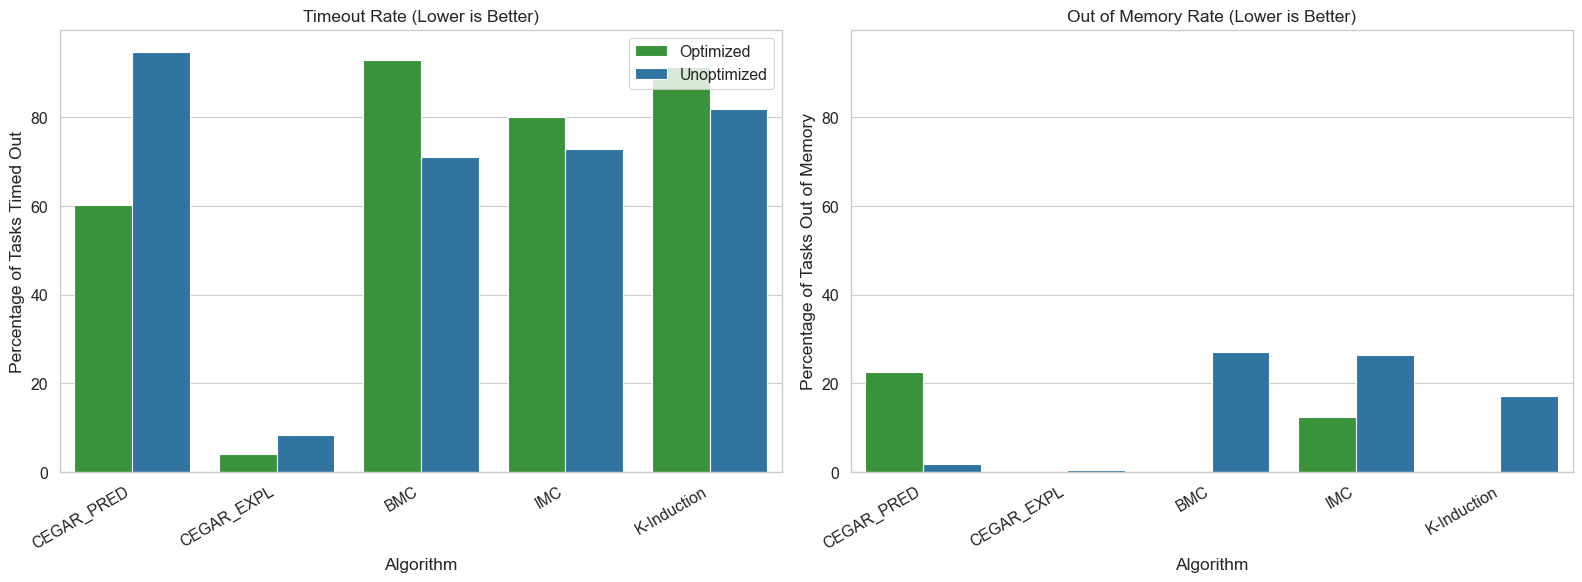


--- Failure Rates Summary ---


Configuration    Optimized                   Unoptimized                 
              OOM Rate (%) Timeout Rate (%) OOM Rate (%) Timeout Rate (%)
Algorithm                                                                
BMC                   0.00            92.84        27.08            71.06
CEGAR_EXPL            0.14             4.15         0.57             8.31
CEGAR_PRED           22.64            60.32         1.72            94.70
IMC                  12.46            80.09        26.50            72.78
K-Induction           0.00            91.26        17.05            81.81

In [6]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
DATA_FOLDER = "result_xmls_btor2"

# Format: ("Algorithm", "Optimized File", "Unoptimized File")
PAIRS = [
    ("CEGAR_PRED", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-pred-cegar.btor2-pred.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-pred-cegar.btor2-pred.xml")),
    ("CEGAR_EXPL", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-expl-cegar.btor2-expl.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-expl-cegar.btor2-expl.xml")),
     ("BMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-bounded.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-bounded.btor2.xml")),
     ("IMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-imc.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-imc.btor2.xml")),
     ("K-Induction", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-kind.btor2.xml"), 
     os.path.join(DATA_FOLDER, "btor2-algos-no-opt.2025-12-07_02-12-15.results.btor2-kind.btor2.xml")),
]

# --- Helper Function ---
def get_failure_stats(filepath):
    """
    Parses an XML file to calculate Timeout and Out of Memory (OOM) rates.
    """
    if not os.path.exists(filepath):
        print(f"Warning: File not found: {filepath}")
        return None

    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        
        total_count = 0
        timeout_count = 0
        oom_count = 0
        
        for run in root.findall('.//run'):
            total_count += 1
            
            # Get status string (e.g., "TIMEOUT (900s)", "OUT OF MEMORY")
            cols = {elem.get('title'): elem.get('value') for elem in run.findall('column')}
            status = cols.get('status', run.get('status', '')).upper()
            
            if 'TIMEOUT' in status:
                timeout_count += 1
            elif 'OUT OF MEMORY' in status:
                oom_count += 1
                
        # Calculate Rates
        timeout_rate = (timeout_count / total_count * 100) if total_count > 0 else 0
        oom_rate = (oom_count / total_count * 100) if total_count > 0 else 0
        
        return timeout_rate, oom_rate

    except Exception as e:
        print(f"Error parsing {filepath}: {e}")
        return None

# --- Main Logic ---
failure_data = []

print("Processing files for failure analysis...")
for algo_name, opt_file, no_opt_file in PAIRS:
    
    # 1. Optimized Stats
    stats_opt = get_failure_stats(opt_file)
    if stats_opt:
        failure_data.append({
            'Algorithm': algo_name,
            'Configuration': 'Optimized',
            'Timeout Rate (%)': stats_opt[0],
            'OOM Rate (%)': stats_opt[1]
        })
        
    # 2. Unoptimized Stats
    stats_no_opt = get_failure_stats(no_opt_file)
    if stats_no_opt:
        failure_data.append({
            'Algorithm': algo_name,
            'Configuration': 'Unoptimized',
            'Timeout Rate (%)': stats_no_opt[0],
            'OOM Rate (%)': stats_no_opt[1]
        })

# Create DataFrame
df_fail = pd.DataFrame(failure_data)

# --- Visualization ---
if not df_fail.empty:
    sns.set_style("whitegrid")
    
    # Create 2 subplots (one for Timeout, one for OOM)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Palette: Green for Optimized, Blue/Gray for Unoptimized
    custom_palette = {"Optimized": "#2ca02c", "Unoptimized": "#1f77b4"}
    
    # 1. Timeout Rate Plot
    sns.barplot(data=df_fail, x='Algorithm', y='Timeout Rate (%)', hue='Configuration', ax=axes[0], palette=custom_palette)
    axes[0].set_title('Timeout Rate (Lower is Better)')
    axes[0].set_ylabel('Percentage of Tasks Timed Out')
    axes[0].legend(loc='upper right')
    
    # 2. OOM Rate Plot
    sns.barplot(data=df_fail, x='Algorithm', y='OOM Rate (%)', hue='Configuration', ax=axes[1], palette=custom_palette)
    axes[1].set_title('Out of Memory Rate (Lower is Better)')
    axes[1].set_ylabel('Percentage of Tasks Out of Memory')
    axes[1].get_legend().remove()
    
    # Formatting Labels
    for ax in axes:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        # Dynamic Y-limit with a small buffer
        max_val = max(df_fail['Timeout Rate (%)'].max(), df_fail['OOM Rate (%)'].max())
        ax.set_ylim(0, max_val + 5)

    plt.tight_layout()
    plt.show()
    
    # --- Summary Table ---
    print("\n--- Failure Rates Summary ---")
    df_pivot = df_fail.pivot(index='Algorithm', columns='Configuration')
    df_pivot = df_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1)
    display(df_pivot.round(2))
else:
    print("No data processed. Check file paths.")